## This guidebook demonstrates how to identify the top external organizations JUUL empoyees communiicated with using email network analysis. We will use centrality measures to determine the most influential individuals in the network.

### Import the required libraries

In [1]:
import polars as pl
from src.util import extract_emails
from src.api.ucsf_api import IndustryDocsSearch
import re
import matplotlib.pyplot as plt
import networkx as nx
import plotly.graph_objs as go



Sanity check: Check for duplicate document ids

In [2]:

df = pl.read_parquet('juul_documents_metadata.parquet') #modify the file name as required
df = df.unique(subset=["id"])


### Step 1: Data Preparation
Extracting the author name and email) followed by addition of the relevant tag

In [3]:
# Define domains to be excluded - focus on external communication as the following domains are related to JUUL employees
exclude_domains = ['juul.com', 'pax.com', 'ploom.com', 'juullabs.com']

# Extract author emails without filtering by domain
author_emails = extract_emails(df, ['author'])

# Extract copied and recipient emails, filtering by domain
copied_recipient_emails = extract_emails(df, ['copied', 'recipient'], exclude_domains=exclude_domains)

# Combine all extracted emails
combined_emails = author_emails + copied_recipient_emails

api = IndustryDocsSearch()
api.results = combined_emails

# Save to Parquet
api.save('juul_external_emails.parquet')

Example of output from juul_external_emails.parquet

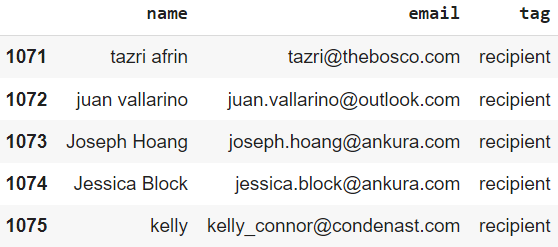

### Step 2: Count frequency of email addresses
Use value_counts() to count the occurrences of each email address and top 50 email addresses for each category.

In [4]:
df = pl.read_parquet('juul_external_emails.parquet')
# Create separate DataFrames based on the 'tag' column
author_df = df.filter(pl.col('tag') == 'author')
recipient_df = df.filter(pl.col('tag') == 'recipient')
copied_df = df.filter(pl.col('tag') == 'copied')

# Count unique email addresses and their frequencies
author_frequencies = author_df.select('email').to_series().value_counts(sort=True)
recipient_frequencies = recipient_df.select('email').to_series().value_counts(sort=True)
copied_frequencies = copied_df.select('email').to_series().value_counts(sort=True)

# # Count unique email addresses and their frequencies (Top 50)
author_frequencies_top50 = author_frequencies.head(50) # modify the number to view the top X as required
recipient_frequencies_top50 = recipient_frequencies.head(50) # modify the number to view the top X as required
copied_frequencies_top50 = copied_frequencies.head(50) # modify the number to view the top X as required

In [5]:
# View the counts (Optional)
print(author_frequencies,recipient_frequencies, copied_frequencies)
print(author_frequencies_top50, recipient_frequencies_top50, copied_frequencies_top50, )

shape: (3_327, 2)
┌─────────────────────────────────┬───────┐
│ email                           ┆ count │
│ ---                             ┆ ---   │
│ str                             ┆ u32   │
╞═════════════════════════════════╪═══════╡
│ app@getfeedback.com             ┆ 4412  │
│ googlealerts-noreply@google.co… ┆ 3776  │
│ alerts@fmaalerts.com            ┆ 3379  │
│ updates@juul.definersconsole.c… ┆ 1437  │
│ chelseakania@pax.com            ┆ 1192  │
│ …                               ┆ …     │
│ xxxxxxxxx@optonline.net         ┆ 1     │
│ cs@vapeshack.com                ┆ 1     │
│ toddk©pax.corn                  ┆ 1     │
│ sonya.grier@american.edu        ┆ 1     │
│ juul@e.juulvapor.com            ┆ 1     │
└─────────────────────────────────┴───────┘ shape: (1_692, 2)
┌─────────────────────────────────┬───────┐
│ email                           ┆ count │
│ ---                             ┆ ---   │
│ str                             ┆ u32   │
╞═════════════════════════════════╪═════

Plot bar charts to visualize the top 50 email frequencies for each category using matplotlib.

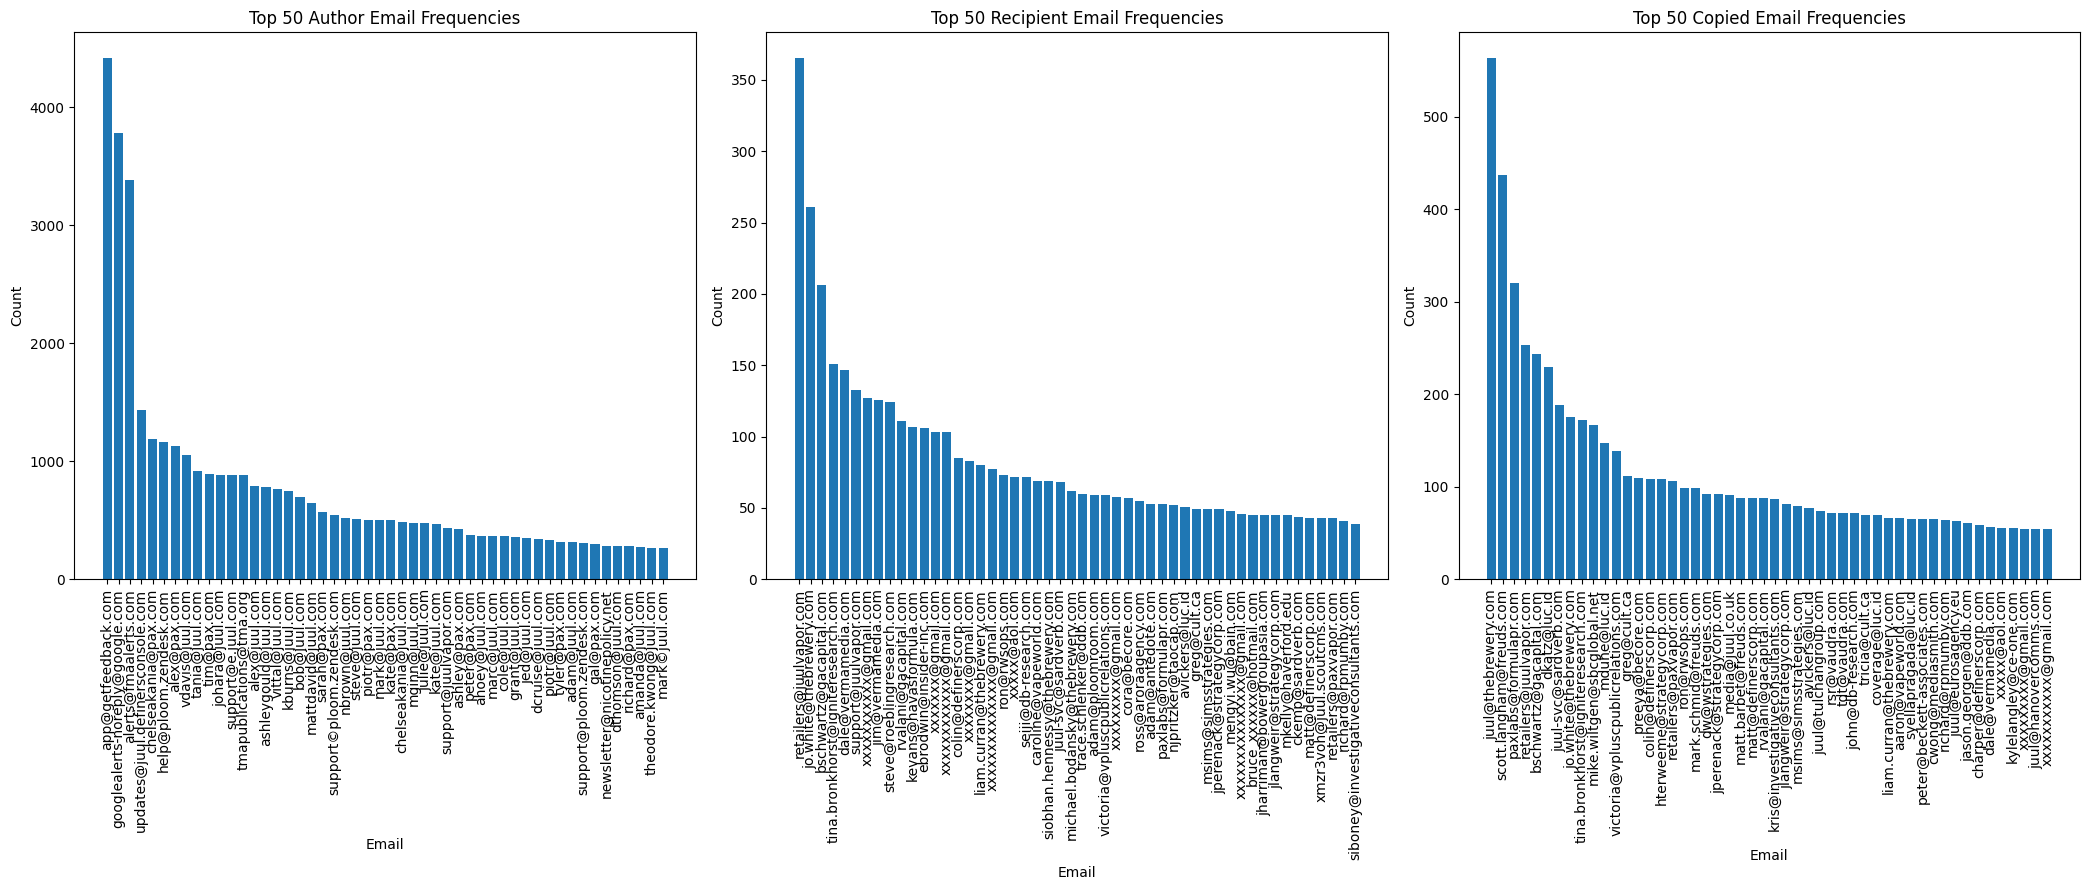

In [6]:
# Visualization of the top 50 for author, copied, and recipient
plt.figure(figsize=(21, 9))

plt.subplot(1, 3, 1)
plt.bar(*author_frequencies_top50)
plt.xticks(rotation=90)
plt.title('Top 50 Author Email Frequencies')
plt.xlabel('Email')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
plt.bar(*recipient_frequencies_top50)
plt.xticks(rotation=90)
plt.title('Top 50 Recipient Email Frequencies')
plt.xlabel('Email')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
plt.bar(*copied_frequencies_top50)
plt.xticks(rotation=90)
plt.title('Top 50 Copied Email Frequencies')
plt.xlabel('Email')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

### Step 3: Create an interactive plot of an email interaction network using NetworkX and Plotly.

#### In an email network, the same pair of nodes (email addresses) can have multiple interaction, we can capture the volume and frequency of email interactions between the same sender and recipient using MultiDiGraph (directed multigraph).

#### The codes also calculates the degree centrality for each node in the graph, which measures the number of connections (both in and out). Nodes with high degree centrality are key players in the network. They are either highly communicative (sending many emails) or highly sought after (receiving many emails).

#### Sorts nodes by degree centrality in descending order and selects the top 50 nodes for ease of visualization.

#### Nodes with 0 connections are removed and the positions of the nodes are computed using the spring layout algorithm, which positions nodes to minimize edge crossings and distribute them evenly.



In [7]:
# Create lists of email interactions for authors and recipients
edges = []
author_index, email_index, tag_index = 0, 1, 2
for row in df.iter_rows():
    if row[tag_index] == 'author':
        author_email = row[email_index]
    elif row[tag_index] == 'recipient':
        recipient_email = row[email_index]
        edges.append((author_email, recipient_email))

# Build the directed graph
G = nx.MultiDiGraph()
G.add_edges_from(edges)

# Calculate degree centrality (combining in-degree and out-degree)
degree_centrality = nx.degree_centrality(G)

# Identify top 50 nodes based on degree centrality
top_50_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:50] # modify the top X number as required.
top_50_nodes_by_degree = [node for node, _ in top_50_degree]

# Create a subgraph with the top 50 nodes
H_sub = G.subgraph(top_50_nodes_by_degree)

# Create a new MultiDiGraph based on the subgraph
H = nx.MultiDiGraph()
H.add_nodes_from(H_sub.nodes(data=True))
H.add_edges_from(H_sub.edges(keys=True, data=True))

# Remove nodes with 0 connections from the new graph
nodes_with_no_edges = [n for n, d in H.degree() if d == 0]
H.remove_nodes_from(nodes_with_no_edges)

# Layout for the graph
pos = nx.spring_layout(H)

# Hover text to mention # of Connections
degrees = dict(H.degree())
hover_texts = [f'Node: {node}<br># of Connections: {degrees[node]}' for node in H.nodes()]

# Extract edge positions and prepare hover text for edges
edge_x = []
edge_y = []
edge_hover_text = []
for edge in H.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])
    # Display the connected nodes in the hover text
    edge_hover_text.extend([f'{edge[0]} - {edge[1]}', f'{edge[0]} - {edge[1]}', None])

edge_trace = go.Scatter(x=edge_x, y=edge_y, line=dict(width=0.5, color='#888'), hoverinfo='text', mode='lines',
                        text=edge_hover_text)

node_x = [pos[node][0] for node in H.nodes()]
node_y = [pos[node][1] for node in H.nodes()]

node_color = [degrees[node] for node in H.nodes()]

node_trace = go.Scatter(x=node_x, y=node_y, mode='markers', hoverinfo='text', text=hover_texts,
                        marker=dict(showscale=True, colorscale='YlGnBu', color=node_color, size=10,
                                    colorbar=dict(thickness=15, title='Node Connections', xanchor='left',
                                                  titleside='right'), line_width=2))

fig = go.Figure(data=[edge_trace, node_trace], layout=go.Layout(showlegend=False, hovermode='closest',
                                                                margin=dict(b=0, l=0, r=0, t=0),
                                                                xaxis=dict(showgrid=False, zeroline=False,
                                                                           showticklabels=False),
                                                                yaxis=dict(showgrid=False, zeroline=False,
                                                                           showticklabels=False)))

fig.show()

In [8]:
#email, degree_centrality
degree_centrality_list = []
for k, v in degree_centrality.items():
    degree_centrality_list.append({"email": k, "degree_centrality": v})
overall_centrality_df = pl.DataFrame(degree_centrality_list)

top_50_centrality_list = []
for k, v in top_50_degree:
    top_50_centrality_list.append({"email": k, "degree_centrality": v})
top_50_centrality_df = pl.DataFrame(top_50_centrality_list, strict=False)

Visualize the graph for the top 50 senders (authors) based on out-degree centrality.

Out-degree centrality measures the number of outgoing edges from a node (individual), indicating its influence in terms of sending emails.

Note: Out-degree centrality might be 0 for nodes that do not have any outgoing edges. This means that the node (email address) did not send any emails to other nodes (individuals) within the dataset or the specified subgraph. Such nodes could either be recipients only, or they could be isolated in terms of sending emails within the context of the analyzed email interactions.

In [9]:
# Create lists of email interactions for authors and recipients
edges = []
author_index, email_index, tag_index = 0, 1, 2
for row in df.iter_rows():
    if row[tag_index] == 'author':
        author_email = row[email_index]
    elif row[tag_index] == 'recipient':
        recipient_email = row[email_index]
        edges.append((author_email, recipient_email))

# Build the directed graph
G = nx.MultiDiGraph()
G.add_edges_from(edges)

# Calculate out-degree centrality
out_degree_centrality = nx.out_degree_centrality(G)

# Identify top 50 nodes based on out-degree centrality
top_50_out_degree = sorted(out_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:50] # modify the top X number as required.
top_50_nodes_by_out_degree = [node for node, _ in top_50_out_degree]

# Create a subgraph with the top 50 nodes
H_sub = G.subgraph(top_50_nodes_by_out_degree)

# Create a new MultiDiGraph based on the subgraph
H = nx.MultiDiGraph()
H.add_nodes_from(H_sub.nodes(data=True))
H.add_edges_from(H_sub.edges(keys=True, data=True))

# Remove nodes with 0 connections from the new graph
nodes_with_no_edges = [n for n, d in H.degree() if d == 0]
H.remove_nodes_from(nodes_with_no_edges)

# Layout for the graph
pos = nx.spring_layout(H, seed = 42)

# Hover text to mention # of Connections
out_degrees = dict(H.out_degree())
hover_texts = [f'Node: {node}<br># of Connections: {out_degrees[node]}' for node in H.nodes()]

# Extract edge positions and prepare hover text for edges
edge_x = []
edge_y = []
edge_hover_text = []
for edge in H.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])
    # Display the connected nodes in the hover text
    edge_hover_text.extend([f'{edge[0]} - {edge[1]}', f'{edge[0]} - {edge[1]}', None])

edge_trace = go.Scatter(x=edge_x, y=edge_y, line=dict(width=0.5, color='#888'), hoverinfo='text', mode='lines',
                        text=edge_hover_text)

node_x = [pos[node][0] for node in H.nodes()]
node_y = [pos[node][1] for node in H.nodes()]

node_color = [out_degrees[node] for node in H.nodes()]
node_trace = go.Scatter(x=node_x, y=node_y, mode='markers', hoverinfo='text', text=[f'Node: {node}<br># of Outgoing Connections: {out_degrees[node]}' for node in H.nodes()],
                        marker=dict(showscale=True, colorscale='YlGnBu', color=node_color, size=10,
                                    colorbar=dict(thickness=15, title='Node Out-Degree', xanchor='left', titleside='right'), line_width=2))

fig = go.Figure(data=[edge_trace, node_trace], layout=go.Layout(showlegend=False, hovermode='closest',
                                                                margin=dict(b=0, l=0, r=0, t=0),
                                                                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                                                                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

fig.show()

In [10]:
out_degree_centrality_list = []
for k, v in out_degree_centrality.items():
    out_degree_centrality_list.append({"email": k, "degree_centrality": v})
overall_out_centrality_df = pl.DataFrame(out_degree_centrality_list)

top_50_out_centrality_list = []
for k, v in top_50_out_degree:
    top_50_out_centrality_list.append({"email": k, "degree_centrality": v})
top_50_out_centrality_df = pl.DataFrame(top_50_out_centrality_list, strict=False)

Visualize the graph for the top 50 recipients based on in-degree centrality.
In-degree centrality measures the number of incoming edges from a node (individual), indicating its influence in terms of receiving emails.

In [11]:
# Create lists of email interactions for authors and recipients
edges = []
author_index, email_index, tag_index = 0, 1, 2
for row in df.iter_rows():
    if row[tag_index] == 'author':
        author_email = row[email_index]
    elif row[tag_index] == 'recipient':
        recipient_email = row[email_index]
        edges.append((author_email, recipient_email))

# Build the directed graph
G = nx.MultiDiGraph()
G.add_edges_from(edges)

# Calculate in-degree centrality
in_degree_centrality = nx.in_degree_centrality(G)

# Identify top 50 nodes based on in-degree centrality
top_50_in_degree = sorted(in_degree_centrality.items(), key=lambda x: x[1], reverse=False)[:50] # modify the top X number as required.
top_50_nodes_by_in_degree = [node for node, _ in top_50_in_degree]

# Create a subgraph with the top 50 nodes
H_sub = G.subgraph(top_50_nodes_by_in_degree)

# Create a new MultiDiGraph based on the subgraph
H = nx.MultiDiGraph()
H.add_nodes_from(H_sub.nodes(data=True))
H.add_edges_from(H_sub.edges(keys=True, data=True))

# Remove nodes with 0 connections from the new graph
nodes_with_no_edges = [n for n, d in H.degree() if d == 0]
H.remove_nodes_from(nodes_with_no_edges)

# Layout for the graph
pos = nx.spring_layout(H, seed = 42)

# Hover text to mention # of Connections
in_degrees = dict(H.in_degree())
hover_texts = [f'Node: {node}<br># of Connections: {in_degrees[node]}' for node in H.nodes()]

# Extract edge positions and prepare hover text for edges
edge_x = []
edge_y = []
edge_hover_text = []
for edge in H.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])
    # Display the connected nodes in the hover text
    edge_hover_text.extend([f'{edge[0]} - {edge[1]}', f'{edge[0]} - {edge[1]}', None])

edge_trace = go.Scatter(x=edge_x, y=edge_y, line=dict(width=0.5, color='#888'), hoverinfo='text', mode='lines',
                        text=edge_hover_text)

node_x = [pos[node][0] for node in H.nodes()]
node_y = [pos[node][1] for node in H.nodes()]

node_color = [in_degrees[node] for node in H.nodes()]
node_trace = go.Scatter(x=node_x, y=node_y, mode='markers', hoverinfo='text', text=[f'Node: {node}<br># of Incoming Connections: {in_degrees[node]}' for node in H.nodes()],
                        marker=dict(showscale=True, colorscale='YlGnBu', color=node_color, size=10,
                                    colorbar=dict(thickness=15, title='Node In-Degree', xanchor='left', titleside='right'), line_width=2))

fig = go.Figure(data=[edge_trace, node_trace], layout=go.Layout(showlegend=False, hovermode='closest',
                                                                margin=dict(b=0, l=0, r=0, t=0),
                                                                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                                                                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

fig.show()


In [12]:
in_degree_centrality_list = []
for k, v in in_degree_centrality.items():
    in_degree_centrality_list.append({"email": k, "degree_centrality": v})
overall_in_centrality_df = pl.DataFrame(in_degree_centrality_list)

top_50_in_centrality_list = []
for k, v in top_50_in_degree:
    top_50_in_centrality_list.append({"email": k, "degree_centrality": v})
top_50_in_centrality_df = pl.DataFrame(top_50_in_centrality_list, strict=False)

Visualize the graph for the top 50 cc'ed individuals based on in-degree centrality. In-degree centrality measures the number of incoming edges from a node (individual), indicating its influence in terms of receiving emails.

In [13]:
# Create lists of email interactions for copied (cc'd)
edges = []
author_index, email_index, tag_index = 0, 1, 2
for row in df.iter_rows():
    if row[tag_index] == 'author':
        author_email = row[email_index]
    elif row[tag_index] == 'copied':
        copied_email = row[email_index]
        edges.append((author_email, copied_email))

# Build the directed graph
G = nx.MultiDiGraph()
G.add_edges_from(edges)

# Calculate in-degree centrality (since copied nodes are like recipients)
copied_degree_centrality = nx.in_degree_centrality(G)

# Identify top 50 nodes based on copied degree centrality
top_50_copied_degree = sorted(copied_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:50] # modify the top X number as required.
top_50_nodes_by_copied_degree = [node for node, _ in top_50_copied_degree]

# Create a subgraph with the top 50 nodes
H_sub = G.subgraph(top_50_nodes_by_copied_degree)

# Create a new MultiDiGraph based on the subgraph
H = nx.MultiDiGraph()
H.add_nodes_from(H_sub.nodes(data=True))
H.add_edges_from(H_sub.edges(keys=True, data=True))

# Remove nodes with 0 connections from the new graph
nodes_with_no_edges = [n for n, d in H.degree() if d == 0]
H.remove_nodes_from(nodes_with_no_edges)

# Layout for the graph without a seed or with different seeds
pos = nx.spring_layout(H, seed=42)

# Hover text to mention # of Connections
copied_degrees = dict(H.in_degree())
hover_texts = [f'Node: {node}<br># of Connections: {copied_degrees[node]}' for node in H.nodes()]

# Extract edge positions and prepare hover text for edges
edge_x = []
edge_y = []
edge_hover_text = []
for edge in H.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])
    # Display the connected nodes in the hover text
    edge_hover_text.extend([f'{edge[0]} - {edge[1]}', f'{edge[0]} - {edge[1]}', None])

edge_trace = go.Scatter(x=edge_x, y=edge_y, line=dict(width=0.5, color='#888'), hoverinfo='text', mode='lines',
                        text=edge_hover_text)

node_x = [pos[node][0] for node in H.nodes()]
node_y = [pos[node][1] for node in H.nodes()]

node_color = [copied_degrees[node] for node in H.nodes()]
node_trace = go.Scatter(x=node_x, y=node_y, mode='markers', hoverinfo='text', text=[f'Node: {node}<br># of Incoming Connections: {copied_degrees[node]}' for node in H.nodes()],
                        marker=dict(showscale=True, colorscale='YlGnBu', color=node_color, size=10,
                                    colorbar=dict(thickness=15, title='Node Copied-Degree', xanchor='left', titleside='right'), line_width=2))

fig = go.Figure(data=[edge_trace, node_trace], layout=go.Layout(showlegend=False, hovermode='closest',
                                                                margin=dict(b=0, l=0, r=0, t=0),
                                                                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                                                                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

fig.show()

In [14]:
in_degree_C_centrality_list = []
for k, v in copied_degree_centrality.items():
    in_degree_C_centrality_list.append({"email": k, "degree_centrality": v})
overall_in_degree_C_centrality_df = pl.DataFrame(in_degree_C_centrality_list)

top_50_in_degree_C_centrality_list = []
for k, v in top_50_copied_degree:
    top_50_in_degree_C_centrality_list.append({"email": k, "degree_centrality": v})
top_50_in_degree_C_centrality_df = pl.DataFrame(top_50_in_degree_C_centrality_list, strict=False)

Run the code cell below to see the network of all individuals an email address has interacted with (both sent and received).

In [15]:
def create_email_graph(df, email):
    # Create lists of email interactions for authors and recipients
    edges = []
    author_index, email_index, tag_index = 0, 1, 2
    for row in df.iter_rows():
        if row[tag_index] == 'author':
            author_email = row[email_index]
        elif row[tag_index] == 'recipient':
            recipient_email = row[email_index]
            edges.append((author_email, recipient_email))
        elif row[tag_index] == 'copied':
            copied_email = row[email_index]
            if author_email in author_emails:
                edges.append((author_email, copied_email))

    # Build the directed graph
    G = nx.MultiDiGraph()
    G.add_edges_from(edges)

    # Check if the specified email is in the graph
    if email not in G:
        print(f"Email {email} not found in the dataset.")
        return

    # Create a subgraph centered around the specified email including its neighbors (interacted with)
    neighbors = list(G.successors(email)) + list(G.predecessors(email))
    sub_nodes = [email] + neighbors
    H_sub = G.subgraph(sub_nodes)

    # Calculate degree centrality for the specified node and its neighbors
    degree_centrality = nx.degree_centrality(H_sub)
    out_degrees = dict(H_sub.out_degree())
    in_degrees = dict(H_sub.in_degree())

    # Combine the centrality scores into a single DataFrame
    centrality_data = {
        'Email': list(H_sub.nodes()),
        'Degree Centrality': [degree_centrality[node] for node in H_sub.nodes()],
        'Out-Degree': [out_degrees[node] for node in H_sub.nodes()],
        'In-Degree': [in_degrees[node] for node in H_sub.nodes()]}
    centrality_df = pl.DataFrame(centrality_data)
    # file_name = f'centrality_scores_{email.replace("@", "_at_").replace(".", "_")}.parquet'
    # centrality_df.write_parquet(file_name) # save score if required

    # Set a seed for reproducibility
    pos = nx.spring_layout(H_sub, seed=42)

    # Hover text to mention # of Connections
    hover_texts = [f'Node: {node}<br># of Outgoing Connections: {out_degrees[node]}<br># of Incoming Connections: {in_degrees[node]}' for node in H_sub.nodes()]

    # Extract edge positions and prepare hover text for edges
    edge_x = []
    edge_y = []
    edge_hover_text = []
    for edge in H_sub.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
        edge_hover_text.extend([f'{edge[0]} - {edge[1]}', f'{edge[0]} - {edge[1]}', None])

    edge_trace = go.Scatter(x=edge_x, y=edge_y, line=dict(width=0.5, color='#888'), hoverinfo='text', mode='lines',
                            text=edge_hover_text)

    node_x = [pos[node][0] for node in H_sub.nodes()]
    node_y = [pos[node][1] for node in H_sub.nodes()]

    node_color = [degree_centrality[node] for node in H_sub.nodes()]
    node_trace = go.Scatter(x=node_x, y=node_y, mode='markers', hoverinfo='text', text=hover_texts,
                            marker=dict(showscale=True, colorscale='YlGnBu', color=node_color, size=10,
                                        colorbar=dict(thickness=15, title='Node Degree Centrality', xanchor='left', titleside='right'), line_width=2))

    fig = go.Figure(data=[edge_trace, node_trace], layout=go.Layout(showlegend=False, hovermode='closest',
                                                                    margin=dict(b=0, l=0, r=0, t=0),
                                                                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                                                                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

    fig.show()



In [16]:
create_email_graph(df, 'jo.white@thebrewery.com')